# **🫁 Lung Cancer Image Classification - Preprocessing Pipeline**

## 📋 Project Overview
**Goal:** Build a deep learning model to classify lung CT scan images as **Normal** or **Malignant** (cancerous)

**This Notebook Covers:**
- ✅ Data loading and preprocessing
- ✅ Image enhancement using CLAHE
- ✅ Data augmentation strategies
- ✅ Dataset splitting (train/validation/test)
- ✅ Data visualization

---

## 🎯 Why Preprocessing Matters?
Medical images often have:
- Low contrast (hard to see differences)
- Varying sizes and orientations
- Different brightness levels

Proper preprocessing helps the model learn better patterns!

## 📦 Import Libraries

**What each library does:**

- **`torch`** - PyTorch deep learning framework
- **`torchvision`** - Image processing tools for PyTorch (datasets, transforms, models)
- **`cv2` (OpenCV)** - Computer vision library (we use it for CLAHE enhancement)
- **`PIL` (Python Imaging Library)** - Basic image loading and manipulation
- **`numpy`** - Numerical operations on arrays
- **`matplotlib/seaborn`** - Data visualization
- **`tqdm`** - Progress bars for loops (makes waiting less boring!)
- **`pandas`** - Data analysis (if needed)

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image

## ⚙️ Configuration Constants

**Why these specific values?**

- **`DATA_DIR`** - Path to your organized dataset folders (train/val/test)
  
- **`BATCH_SIZE = 32`** - Number of images processed together
  - **Why 32?** Good balance between:
    - **Memory usage** (32 images fit in most GPUs)
    - **Training speed** (processes 32 at once, faster than 1 at a time)
    - **Gradient stability** (averages over 32 samples reduces noise)
  - Common choices: 16, 32, 64, 128
  
- **`IMAGE_SIZE = 224`** - Standard input size for most pretrained models
  - **Why 224?** Most ImageNet pretrained models (ResNet, VGG, EfficientNet) expect 224×224 images
  - Using standard size lets us use transfer learning later!

In [2]:
# CONSTANTS

# DATA_DIR = "F:/Machine Learning/PyTorch/Lung_Cancer/Final_Split_Data"
DATA_DIR = "/content/drive/MyDrive/Final_Split_Data"
BATCH_SIZE = 32
IMAGE_SIZE = 224 # 224x224 image pixels


In [3]:
DATA_DIR

'/content/drive/MyDrive/Final_Split_Data'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
print(f"🖥️  Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"⚡ CUDA Available: {torch.cuda.is_available()}")
print(f"📊 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Test actual speed
import time
x = torch.randn(1000, 1000).cuda()
start = time.time()
y = x @ x
torch.cuda.synchronize()
print(f"⏱️  GPU Speed Test: {(time.time()-start)*1000:.2f}ms")

🖥️  Device: Tesla T4
⚡ CUDA Available: True
📊 GPU Memory: 15.83 GB
⏱️  GPU Speed Test: 114.20ms


## 🔍 Custom CLAHE Transform

### What is CLAHE?
**CLAHE** = Contrast Limited Adaptive Histogram Equalization

### Why do we need it?
- Medical images (CT scans) often have **low contrast**
- Hard to see subtle differences between normal and cancerous tissue
- CLAHE **enhances local contrast** without over-amplifying noise

### How CLAHE works:
1. **Divides image into small tiles** (8×8 grid)
2. **Applies histogram equalization to each tile separately** (enhances local details)
3. **Limits contrast amplification** (`clip_limit=2.0` prevents noise explosion)
4. **Blends tile boundaries smoothly** (avoids checkerboard effect)

### Key Parameters:
- **`clip_limit=2.0`** - Controls maximum contrast enhancement
  - Lower = less enhancement (0.5-1.0 for subtle)
  - Higher = more enhancement (2.0-4.0 for aggressive)
  - We use 2.0 as a balanced middle ground
  
- **`tile_grid_size=(8, 8)`** - Divides image into 8×8 = 64 tiles
  - Smaller tiles (4×4) = more local enhancement
  - Larger tiles (16×16) = more global enhancement

### Why LAB Color Space for RGB images?
- LAB separates **luminance (L)** from **color (A, B)**
- We only enhance luminance channel → preserves original colors
- Converts: RGB → LAB → Enhance L → RGB

In [6]:
class ApplyCLAHE:
    def __init__(self, clip_limit=1, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):

        # convert PIL image to numpy array
        img_np = np.array(img)

        # apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)

        # if gray scale
        if len(img_np.shape) == 2:
            img_clahe = clahe.apply(img_np)

        # if RGB, apply to each channel
        else:
            img_clahe = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
            img_clahe[:, :, 0] = clahe.apply(img_clahe[:, :, 0])
            img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_LAB2RGB)

        return Image.fromarray(img_clahe)

## 🔄 Training Data Transforms (with Augmentation)

### Transform Pipeline Explained:

**1. `Grayscale(num_output_channels=1)`** - Convert to grayscale
   - **Why?** Lung CT scans don't need color, tissue structure matters more
   - Reduces data from 3 channels (RGB) to 1 channel

**2. `ApplyCLAHE(clip_limit=2.0)`** - Enhance contrast
   - Makes tissue differences more visible
   - Helps model detect subtle patterns

**3. `Grayscale(num_output_channels=3)`** - Convert back to 3-channel
   - **Why?** Pretrained models expect 3-channel input (RGB)
   - Simply triplicates the grayscale channel: [G] → [G, G, G]

**4. `Resize((234, 234))` + `RandomCrop((224, 224))`** - Augmentation!
   - Resize to slightly larger (234×234)
   - Then randomly crop to 224×224
   - **Why?** Each epoch sees different crops → model learns to be position-invariant
   - Prevents overfitting by adding variety

**5. `ToTensor()`** - Convert PIL Image → PyTorch Tensor
   - Changes range from [0, 255] → [0.0, 1.0]
   - Changes shape from (H, W, C) → (C, H, W)

**6. `Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])`**
   - **Why these numbers?** ImageNet statistics (standard for transfer learning)
   - Formula: `(pixel - mean) / std`
   - Centers data around 0, makes training more stable
   - Required if using pretrained models!

In [7]:
# tranformers (grayscale, resize, to tensor, normalize)

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE + 10, IMAGE_SIZE + 10)),
    transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

## ✅ Validation/Test Transforms (Deterministic)

### Key Difference from Training Transforms:

**NO Random Augmentation!**
- **Training:** Uses `RandomCrop` → different crops each time
- **Val/Test:** Direct `Resize` → same image every time

### Why No Augmentation for Val/Test?
- **Consistency:** We want to evaluate model performance on same images
- **Fair comparison:** Results should be reproducible
- **Real-world simulation:** During deployment, you'll use raw images

### Transform Pipeline:
1. **Grayscale** → CLAHE enhancement → **3-channel**
2. **Direct resize to 224×224** (no random crop)
3. **ToTensor** + **Normalize** (same as training)

This ensures val/test preprocessing matches training preprocessing exactly, except for randomness!

In [8]:
# Val/Test transforms (deterministic)
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Direct resize, no crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

## 📂 Load Datasets

### What is `ImageFolder`?
PyTorch's convenient dataset loader that expects this structure:
```
Final_Split_Data/
├── train/
│   ├── Malignant/   (all cancer images here)
│   └── Normal/      (all normal images here)
├── val/
│   ├── Malignant/
│   └── Normal/
└── test/
    ├── Malignant/
    └── Normal/
```

### How it Works:
- **Automatically assigns labels** based on folder names
  - Malignant = class 0 or 1
  - Normal = class 0 or 1
- **Applies transforms** to each image when loading
- **Returns:** (image_tensor, label) pairs

### Why Separate Datasets?
- **Training set:** Used to learn patterns (largest split, ~70-80%)
- **Validation set:** Tune hyperparameters, check overfitting (~10-15%)
- **Test set:** Final evaluation, never seen during training (~10-15%)

In [9]:
# laod dataset

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=val_test_transforms)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_test_transforms)

## 🔄 Create DataLoaders

### What is a DataLoader?
A DataLoader wraps a dataset and provides:
- **Batching:** Groups images into batches
- **Shuffling:** Randomizes order (for training only)
- **Parallel loading:** Loads data in background while model trains
- **Memory management:** Efficient data transfer to GPU

### Parameter Explanations:

**`batch_size=32`**
- Processes 32 images at once
- GPU computes gradients for all 32, then averages them

**`shuffle=True` (training only)**
- **Training:** `shuffle=True` → random order each epoch (prevents learning order patterns)
- **Val/Test:** `shuffle=False` → same order (consistency)

**`num_workers=2`**
- Uses 2 CPU threads to load data in background
- **Why 2?** Good balance for most systems
  - 0 = single-threaded (slow, blocks training)
  - 2-4 = parallel loading (faster, keeps GPU busy)
  - Too many = memory overhead

**`pin_memory=False`**
- `True` = faster GPU transfer (but uses more RAM)
- `False` = slower transfer (but safer for limited RAM)

**`persistent_workers=True`**
- Keeps workers alive between epochs
- **Benefit:** Faster epoch transitions (no worker restart overhead)
- **Cost:** Uses more memory

### Output Explanation:
- **Dataset sizes:** Total number of images
- **Loader sizes:** Number of batches (images ÷ batch_size)

In [10]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ Data loaded successfully!")
print("✅ Classes : ", train_dataset.classes)
print("✅ Dataset sizes : Train", len(train_dataset))
print("✅ Dataset sizes : Validation", len(val_dataset))
print("✅ Dataset sizes : Test", len(test_dataset))

✅ Data loaded successfully!
✅ Classes :  ['Malignant', 'Normal']
✅ Dataset sizes : Train 3408
✅ Dataset sizes : Validation 426
✅ Dataset sizes : Test 428


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
print(len(train_loader), len(val_loader), len(test_loader))

107 14 14


## 🛠️ Error Handling for Corrupted Images

### What does this do?
**`LOAD_TRUNCATED_IMAGES = True`** allows PIL to load partially corrupted images

### Why needed?
- Sometimes image files get corrupted during download/transfer
- Without this, training crashes with "image file truncated" error
- With this, PIL attempts to load as much as possible

### When to use:
- Large datasets downloaded from internet
- Medical imaging datasets (often have file issues)
- Any dataset where you can't manually verify every image

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## 📊 Visualize Class Distribution

### Why check class distribution?

**Class Imbalance Problem:**
- If dataset has 900 Normal and 100 Malignant images
- Model might just predict "Normal" for everything → 90% accuracy!
- But it never learned to detect cancer (terrible for medical use)

### What to look for:
- ✅ **Balanced:** Both classes have similar counts (~50/50)
- ⚠️ **Slightly imbalanced:** 60/40 or 70/30 (often okay)
- ❌ **Severely imbalanced:** 90/10 or worse (needs special handling)

### If imbalanced, solutions:
1. **Data augmentation** (generate more samples for minority class) ← I did this offline!
2. **Class weights** (penalize model more for minority class errors)
3. **Oversampling/Undersampling**
4. **Use F1-score instead of accuracy**

### This Plot Shows:
- Red bar = Malignant images count
- Green bar = Normal images count
- Ideally should be roughly equal!

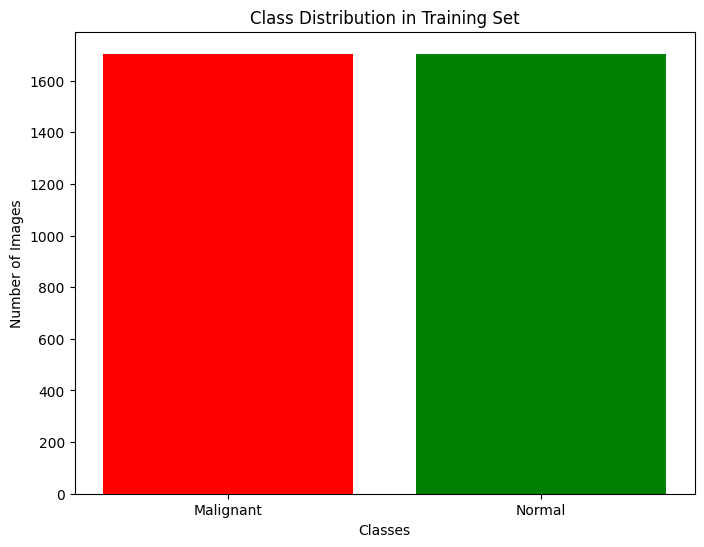

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

labels = train_dataset.targets
label_counts = Counter(labels)

class_names = train_dataset.classes
class_labels = [class_names[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(class_labels, counts, color=['red', 'green'])
plt.title("Class Distribution in Training Set")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

## 🖼️ Visualize Sample Images

### Why visualize?

**Quality Control:**
1. ✅ **Verify transforms work:** Are images properly enhanced?
2. ✅ **Check labels:** Do labels match images?
3. ✅ **Spot errors:** Are there any corrupted/wrong images?
4. ✅ **Understand data:** What does the model actually see?

### Function Breakdown:

**`show_batch()` function:**
- **Randomly samples** images from dataset
- **Unnormalizes** them (reverses normalization to display properly)
- **Displays in grid** (3 rows × 5 cols = 15 images)

### Why Unnormalize?
- Training images are normalized: `(pixel - 0.485) / 0.229`
- This makes pixel values negative/strange
- To display properly: `pixel = normalized * 0.229 + 0.485`
- Then clamp to [0, 1] range

### What to Check:
- ✅ CLAHE enhancement working? (good contrast)
- ✅ Images clearly visible?
- ✅ Labels match image content?
- ✅ Any obvious corrupted images?

**Pro Tip:** Run this multiple times to see different random samples!

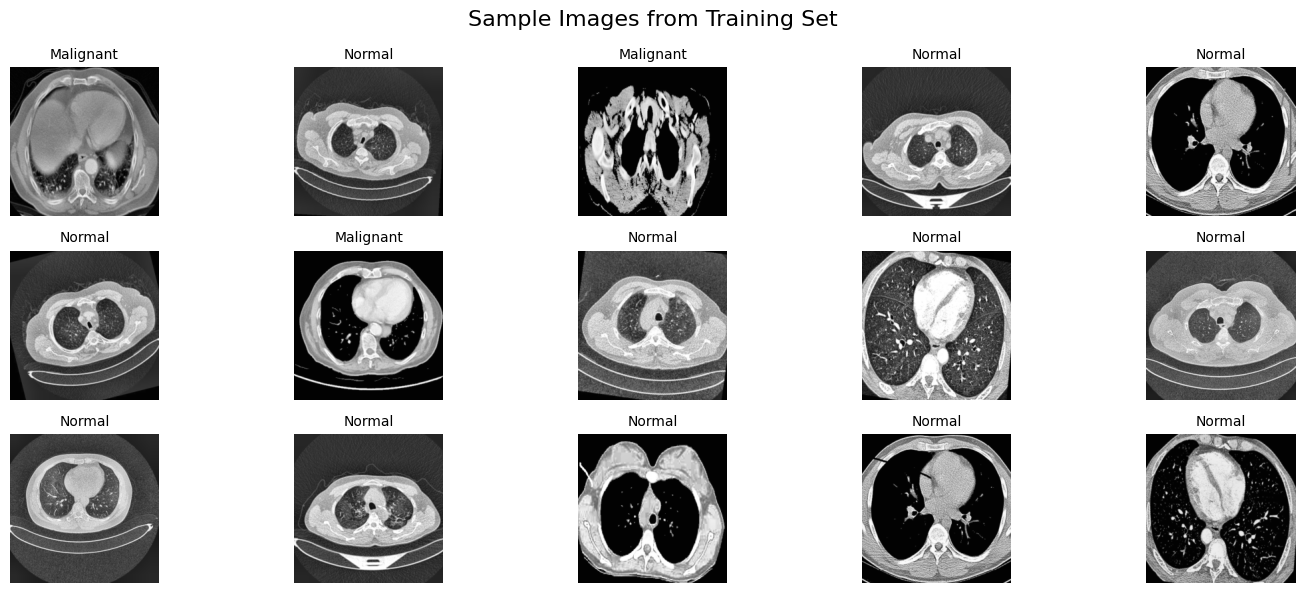

In [14]:
def show_batch(dataset, class_names, num_images=24):

    # Get images directly from dataset (much faster)
    indices = np.random.choice(len(dataset), min(num_images, len(dataset)), replace=False)

    rows = 3
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    # Unnormalize parameters
    mean = torch.tensor([0.485, 0.485, 0.485]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.229, 0.229]).view(3, 1, 1)

    for i, ax in enumerate(axes.flatten()):
        if i < len(indices):
            img, label = dataset[indices[i]]

            # Unnormalize
            img = img * std + mean
            img = torch.clamp(img, 0, 1)

            # Convert to numpy
            img = img.numpy().transpose((1, 2, 0))

            ax.imshow(img, cmap='gray')
            ax.set_title(class_names[label], fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle("Sample Images from Training Set", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call with dataset instead of dataloader
show_batch(train_dataset, train_dataset.classes)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 🧠 CNN Model Architecture

## Architecture Overview:

**Convolutional Blocks:**
1. **Block 1:** Conv(32 filters) → ReLU → MaxPool → Dropout(0.25)
2. **Block 2:** Conv(64 filters) → ReLU → MaxPool → Dropout(0.25)  
3. **Block 3:** Conv(128 filters) → ReLU → MaxPool → Dropout(0.3)

**Fully Connected Layers:**
4. **Flatten** → Converts feature maps to 1D vector
5. **Dense(512)** → ReLU → Dropout(0.5) → High-level feature learning
6. **Dense(2)** → Output layer (Normal vs Malignant)

### Why This Architecture?

**Increasing Filter Depth (32 → 64 → 128):**
- Early layers detect simple patterns (edges, textures)
- Deeper layers combine patterns into complex features (tissue structures)
- More filters = more feature detectors

**MaxPooling:**
- Reduces spatial dimensions (224×224 → 112×112 → 56×56 → 28×28)
- Makes model invariant to small translations
- Reduces computation

**Dropout Strategy:**
- Lower dropout in conv layers (0.25-0.3) - preserve spatial features
- Higher dropout in dense layer (0.5) - prevent overfitting on high-level features
- Critical for medical images (limited data, high overfitting risk)

In [16]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"📊 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  Running on CPU (training will be slower)")

🖥️  Using device: cuda
✅ GPU: Tesla T4
📊 GPU Memory: 15.83 GB


In [17]:
class LungCancerCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(LungCancerCNN, self).__init__()

        # Block 1: Conv(32) → ReLU → MaxPool → Dropout(0.25)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.25)

        # Block 2: Conv(64) → ReLU → MaxPool → Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(0.25)

        # Block 3: Conv(128) → ReLU → MaxPool → Dropout(0.3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(0.3)

        # Calculate flattened size: 224 / 2 / 2 / 2 = 28
        # So feature maps are 28x28x128
        self.flatten_size = 28 * 28 * 128

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

# Initialize model
model = LungCancerCNN(num_classes=2).to(device)
print("✅ Model created successfully!")
print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")

✅ Model created successfully!
📊 Total parameters: 51,475,458


In [18]:
# Model summary
print("=" * 70)
print("🏗️  MODEL ARCHITECTURE")
print("=" * 70)
print(model)
print("=" * 70)

🏗️  MODEL ARCHITECTURE
LungCancerCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)


# ⚙️ Training Configuration

## Loss Function: CrossEntropyLoss
- Perfect for binary classification
- Combines softmax + negative log likelihood
- Automatically handles class probabilities

## Optimizer: Adam
- **Learning rate = 0.001** (default, good starting point)
- Adaptive learning rates per parameter
- Works well for medical image classification

## Learning Rate Scheduler: ReduceLROnPlateau
- Reduces LR when validation loss plateaus
- **Factor = 0.5** (halves LR)
- **Patience = 3** (waits 3 epochs before reducing)
- **Min LR = 1e-6** (prevents LR from getting too small)
- Helps model converge to better minima

In [20]:
# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6,
)

# Training parameters
NUM_EPOCHS = 30
EARLY_STOPPING_PATIENCE = 7

print("✅ Training configuration set!")
print(f"📊 Epochs: {NUM_EPOCHS}")
print(f"⏹️  Early stopping patience: {EARLY_STOPPING_PATIENCE}")

✅ Training configuration set!
📊 Epochs: 30
⏹️  Early stopping patience: 7


# 🏋️ Training & Validation Functions

## Training Function:
1. **Sets model to training mode** (`model.train()`)
2. **Iterates through batches** with progress bar
3. **Forward pass** → compute loss
4. **Backward pass** → compute gradients
5. **Optimizer step** → update weights
6. **Tracks metrics** (loss, accuracy)

## Validation Function:
1. **Sets model to evaluation mode** (`model.eval()`)
2. **Disables gradient computation** (`torch.no_grad()`)
3. **Evaluates on validation set**
4. **Returns metrics** for early stopping decisions

## Key Features:
- ✅ Real-time progress bars (tqdm)
- ✅ Batch-level accuracy tracking
- ✅ Loss averaging
- ✅ GPU memory efficient

In [21]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("✅ Training functions defined!")

✅ Training functions defined!


# 🚀 Training Loop with Early Stopping

## What Happens Here:

**For Each Epoch:**
1. **Train** on training set
2. **Validate** on validation set
3. **Update learning rate** (scheduler)
4. **Track best model** (save if validation loss improves)
5. **Early stopping** (stop if no improvement for 7 epochs)

## Early Stopping:
- Prevents overfitting by stopping when model stops improving
- **Patience = 7** means we wait 7 epochs without improvement
- Saves training time
- Returns best model (not last model!)

## Metrics Tracked:
- ✅ Training loss & accuracy
- ✅ Validation loss & accuracy
- ✅ Learning rate changes
- ✅ Best model checkpoint

In [22]:
# Training loop with early stopping
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'lr': []
}

best_val_loss = float('inf')
best_model_state = None
patience_counter = 0

print("🚀 Starting training...\n")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # Print epoch results
    print(f"\n📊 Results:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"   Learning Rate: {current_lr:.6f}")

    # Check for best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"   ✅ New best model! (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"   ⏳ No improvement ({patience_counter}/{EARLY_STOPPING_PATIENCE})")

    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n⏹️  Early stopping triggered after {epoch+1} epochs!")
        print(f"   Best validation loss: {best_val_loss:.4f}")
        break

print("\n" + "=" * 70)
print("✅ Training completed!")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model loaded (Val Loss: {best_val_loss:.4f})")

🚀 Starting training...


📅 Epoch 1/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 4.8095 | Train Acc: 74.91%
   Val Loss:   0.3154 | Val Acc:   87.79%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.3154)

📅 Epoch 2/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.3355 | Train Acc: 85.42%
   Val Loss:   0.2469 | Val Acc:   89.67%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.2469)

📅 Epoch 3/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.2711 | Train Acc: 88.09%
   Val Loss:   0.2064 | Val Acc:   91.55%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.2064)

📅 Epoch 4/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.2548 | Train Acc: 89.26%
   Val Loss:   0.1706 | Val Acc:   94.13%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.1706)

📅 Epoch 5/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.2544 | Train Acc: 88.91%
   Val Loss:   0.1825 | Val Acc:   93.66%
   Learning Rate: 0.001000
   ⏳ No improvement (1/7)

📅 Epoch 6/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.2219 | Train Acc: 89.94%
   Val Loss:   0.1483 | Val Acc:   95.77%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.1483)

📅 Epoch 7/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.2281 | Train Acc: 90.32%
   Val Loss:   0.1453 | Val Acc:   94.84%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.1453)

📅 Epoch 8/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.2110 | Train Acc: 91.23%
   Val Loss:   0.1427 | Val Acc:   93.90%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.1427)

📅 Epoch 9/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.2012 | Train Acc: 91.08%
   Val Loss:   0.1259 | Val Acc:   96.95%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.1259)

📅 Epoch 10/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.2053 | Train Acc: 91.96%
   Val Loss:   0.1185 | Val Acc:   94.60%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.1185)

📅 Epoch 11/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.2064 | Train Acc: 91.87%
   Val Loss:   0.0989 | Val Acc:   97.65%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.0989)

📅 Epoch 12/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.1554 | Train Acc: 93.57%
   Val Loss:   0.0727 | Val Acc:   97.18%
   Learning Rate: 0.001000
   ✅ New best model! (Val Loss: 0.0727)

📅 Epoch 13/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.1739 | Train Acc: 93.05%
   Val Loss:   0.0855 | Val Acc:   97.65%
   Learning Rate: 0.001000
   ⏳ No improvement (1/7)

📅 Epoch 14/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.1766 | Train Acc: 92.22%
   Val Loss:   0.0957 | Val Acc:   96.71%
   Learning Rate: 0.001000
   ⏳ No improvement (2/7)

📅 Epoch 15/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.1539 | Train Acc: 93.31%
   Val Loss:   0.0861 | Val Acc:   97.65%
   Learning Rate: 0.001000
   ⏳ No improvement (3/7)

📅 Epoch 16/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.1459 | Train Acc: 93.84%
   Val Loss:   0.0744 | Val Acc:   96.48%
   Learning Rate: 0.000500
   ⏳ No improvement (4/7)

📅 Epoch 17/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.1167 | Train Acc: 95.10%
   Val Loss:   0.0498 | Val Acc:   98.59%
   Learning Rate: 0.000500
   ✅ New best model! (Val Loss: 0.0498)

📅 Epoch 18/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.1029 | Train Acc: 95.95%
   Val Loss:   0.0580 | Val Acc:   98.59%
   Learning Rate: 0.000500
   ⏳ No improvement (1/7)

📅 Epoch 19/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0966 | Train Acc: 95.95%
   Val Loss:   0.0525 | Val Acc:   98.12%
   Learning Rate: 0.000500
   ⏳ No improvement (2/7)

📅 Epoch 20/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0939 | Train Acc: 96.57%
   Val Loss:   0.0682 | Val Acc:   98.12%
   Learning Rate: 0.000500
   ⏳ No improvement (3/7)

📅 Epoch 21/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0861 | Train Acc: 96.19%
   Val Loss:   0.0537 | Val Acc:   98.36%
   Learning Rate: 0.000250
   ⏳ No improvement (4/7)

📅 Epoch 22/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0825 | Train Acc: 96.89%
   Val Loss:   0.0584 | Val Acc:   97.89%
   Learning Rate: 0.000250
   ⏳ No improvement (5/7)

📅 Epoch 23/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0638 | Train Acc: 97.59%
   Val Loss:   0.0440 | Val Acc:   98.59%
   Learning Rate: 0.000250
   ✅ New best model! (Val Loss: 0.0440)

📅 Epoch 24/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0628 | Train Acc: 97.74%
   Val Loss:   0.0757 | Val Acc:   97.65%
   Learning Rate: 0.000250
   ⏳ No improvement (1/7)

📅 Epoch 25/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0697 | Train Acc: 96.98%
   Val Loss:   0.0377 | Val Acc:   98.83%
   Learning Rate: 0.000250
   ✅ New best model! (Val Loss: 0.0377)

📅 Epoch 26/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0533 | Train Acc: 97.89%
   Val Loss:   0.0364 | Val Acc:   98.59%
   Learning Rate: 0.000250
   ✅ New best model! (Val Loss: 0.0364)

📅 Epoch 27/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0533 | Train Acc: 97.77%
   Val Loss:   0.0357 | Val Acc:   98.59%
   Learning Rate: 0.000250
   ✅ New best model! (Val Loss: 0.0357)

📅 Epoch 28/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0556 | Train Acc: 97.77%
   Val Loss:   0.0343 | Val Acc:   98.83%
   Learning Rate: 0.000250
   ✅ New best model! (Val Loss: 0.0343)

📅 Epoch 29/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0622 | Train Acc: 97.39%
   Val Loss:   0.0318 | Val Acc:   98.59%
   Learning Rate: 0.000250
   ✅ New best model! (Val Loss: 0.0318)

📅 Epoch 30/30
----------------------------------------------------------------------



📊 Results:
   Train Loss: 0.0580 | Train Acc: 97.42%
   Val Loss:   0.0366 | Val Acc:   98.59%
   Learning Rate: 0.000250
   ⏳ No improvement (1/7)

✅ Training completed!
✅ Best model loaded (Val Loss: 0.0318)


# 📈 Visualize Training History

## What to Look For:

**Training vs Validation Loss:**
- ✅ Both decreasing → model learning well
- ⚠️ Val loss increases while train loss decreases → overfitting
- ⚠️ Both high and flat → underfitting (model too simple)

**Training vs Validation Accuracy:**
- ✅ Both increasing together → good generalization
- ⚠️ Large gap (train >> val) → overfitting
- ⚠️ Both low → model not learning

**Learning Rate Schedule:**
- Shows when LR was reduced (should align with validation plateaus)

## Ideal Pattern:
- Both curves smooth and converging
- Small gap between train and validation
- Steady improvement over time

/tmp/ipython-input-911861783.py:30: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-911861783.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


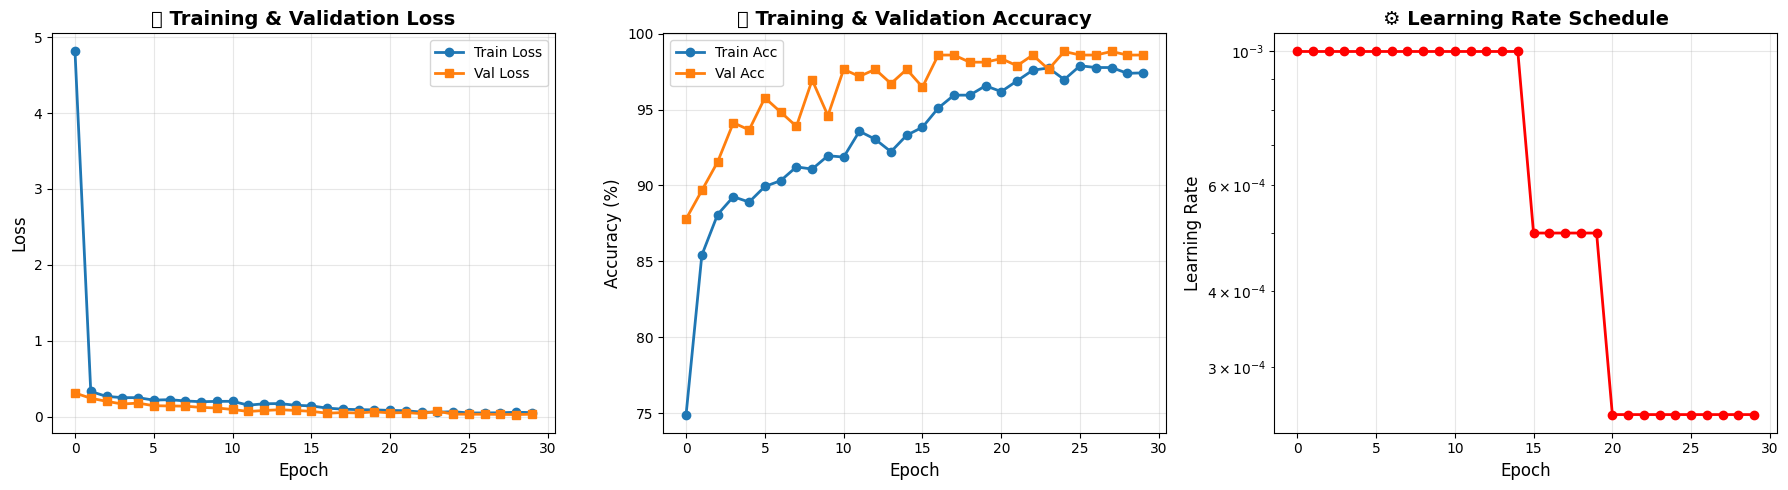


📊 FINAL TRAINING METRICS
Best Validation Loss:     0.0318
Best Validation Accuracy: 98.83%
Final Train Accuracy:     97.42%
Final Val Accuracy:       98.59%


In [23]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('📉 Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', marker='o', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Acc', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('📈 Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning rate plot
axes[2].plot(history['lr'], marker='o', linewidth=2, color='red')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Learning Rate', fontsize=12)
axes[2].set_title('⚙️ Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "=" * 70)
print("📊 FINAL TRAINING METRICS")
print("=" * 70)
print(f"Best Validation Loss:     {min(history['val_loss']):.4f}")
print(f"Best Validation Accuracy: {max(history['val_acc']):.2f}%")
print(f"Final Train Accuracy:     {history['train_acc'][-1]:.2f}%")
print(f"Final Val Accuracy:       {history['val_acc'][-1]:.2f}%")
print("=" * 70)

# 🎯 Test Set Evaluation

## Why Test Set?
- **Never seen during training** (unbiased evaluation)
- **Simulates real-world performance**
- **Final model assessment**

## Metrics We'll Calculate:
1. **Accuracy** - Overall correctness (TP + TN) / Total
2. **Precision** - Of predicted cancers, how many were correct? TP / (TP + FP)
3. **Recall (Sensitivity)** - Of actual cancers, how many did we catch? TP / (TP + FN)
4. **F1-Score** - Harmonic mean of precision and recall
5. **Confusion Matrix** - Visual breakdown of predictions

## For Medical Diagnosis:
- **High Recall** is critical! (Don't miss cancer cases)
- **False Negatives** are dangerous (cancer labeled as normal)
- **False Positives** are less critical (extra screening isn't harmful)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, dataloader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

# Evaluate on test set
print("🧪 Evaluating on test set...\n")
test_preds, test_labels = evaluate_model(model, test_loader, device)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)

print("=" * 70)
print("🎯 TEST SET RESULTS")
print("=" * 70)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%\n")

# Classification report
print("📊 Detailed Classification Report:")
print("-" * 70)
print(classification_report(test_labels, test_preds,
                          target_names=train_dataset.classes,
                          digits=4))
print("=" * 70)

🧪 Evaluating on test set...



Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 14/14 [01:51<00:00,  7.95s/it]

🎯 TEST SET RESULTS

✅ Test Accuracy: 98.83%

📊 Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

   Malignant     0.9816    0.9953    0.9884       214
      Normal     0.9953    0.9813    0.9882       214

    accuracy                         0.9883       428
   macro avg     0.9884    0.9883    0.9883       428
weighted avg     0.9884    0.9883    0.9883       428



# 🔲 Confusion Matrix Visualization

## How to Read:

**Matrix Layout:**
```
                Predicted
              Normal | Malignant
Actual Normal    TN   |   FP
    Malignant    FN   |   TP
```

**What Each Cell Means:**
- **TN (Top-Left):** Correctly identified normal cases ✅
- **TP (Bottom-Right):** Correctly identified cancer cases ✅
- **FP (Top-Right):** Normal classified as cancer ⚠️ (False Alarm)
- **FN (Bottom-Left):** Cancer classified as normal ❌ (Dangerous!)

## Goal:
- **Maximize diagonal** (TN and TP)
- **Minimize off-diagonal** (FP and FN)
- **Especially minimize FN** (missed cancer cases)

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-3242303023.py:25: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


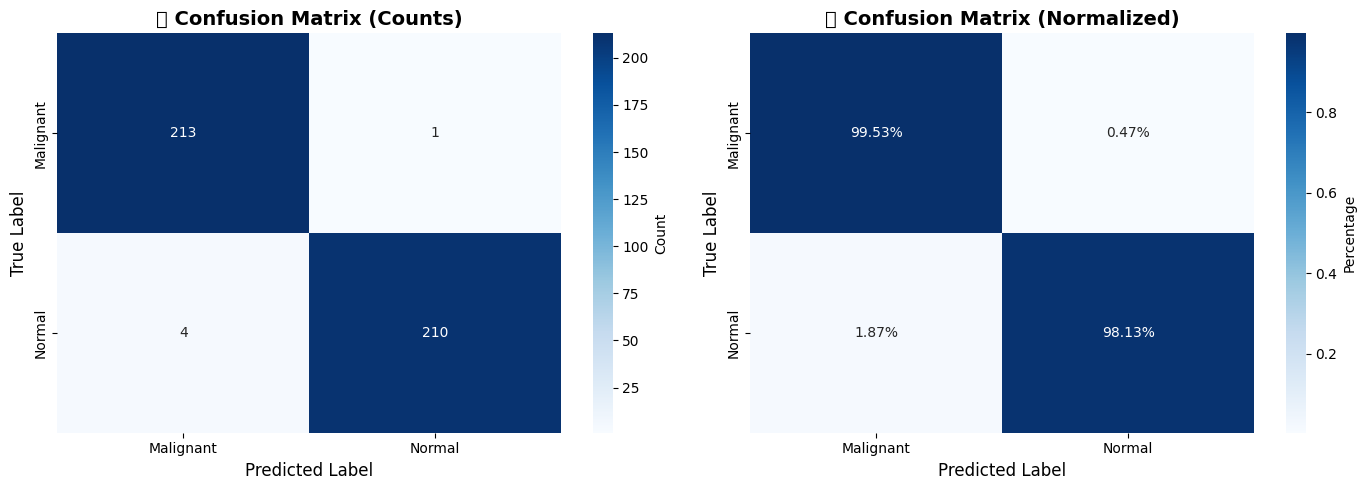


📊 Confusion Matrix Breakdown:
True Negatives (TN):   213 - Normal correctly identified
False Positives (FP):    1 - Normal wrongly labeled as Malignant
False Negatives (FN):    4 - Malignant wrongly labeled as Normal ⚠️
True Positives (TP):   210 - Malignant correctly identified


In [25]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('🔲 Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes,
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('🔲 Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# Print confusion matrix interpretation
print("\n📊 Confusion Matrix Breakdown:")
print("=" * 70)
print(f"True Negatives (TN):  {cm[0][0]:4d} - Normal correctly identified")
print(f"False Positives (FP): {cm[0][1]:4d} - Normal wrongly labeled as Malignant")
print(f"False Negatives (FN): {cm[1][0]:4d} - Malignant wrongly labeled as Normal ⚠️")
print(f"True Positives (TP):  {cm[1][1]:4d} - Malignant correctly identified")
print("=" * 70)

# 🖼️ Visualize Predictions

## What This Shows:
- **Random sample** of test images
- **True labels** vs **predicted labels**
- **Correct predictions** in green ✅
- **Incorrect predictions** in red ❌

## Analysis:
- Look for patterns in errors
- Are certain types of images harder to classify?
- Do misclassifications make visual sense?
- Quality control for model behavior

/tmp/ipython-input-2194269768.py:47: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


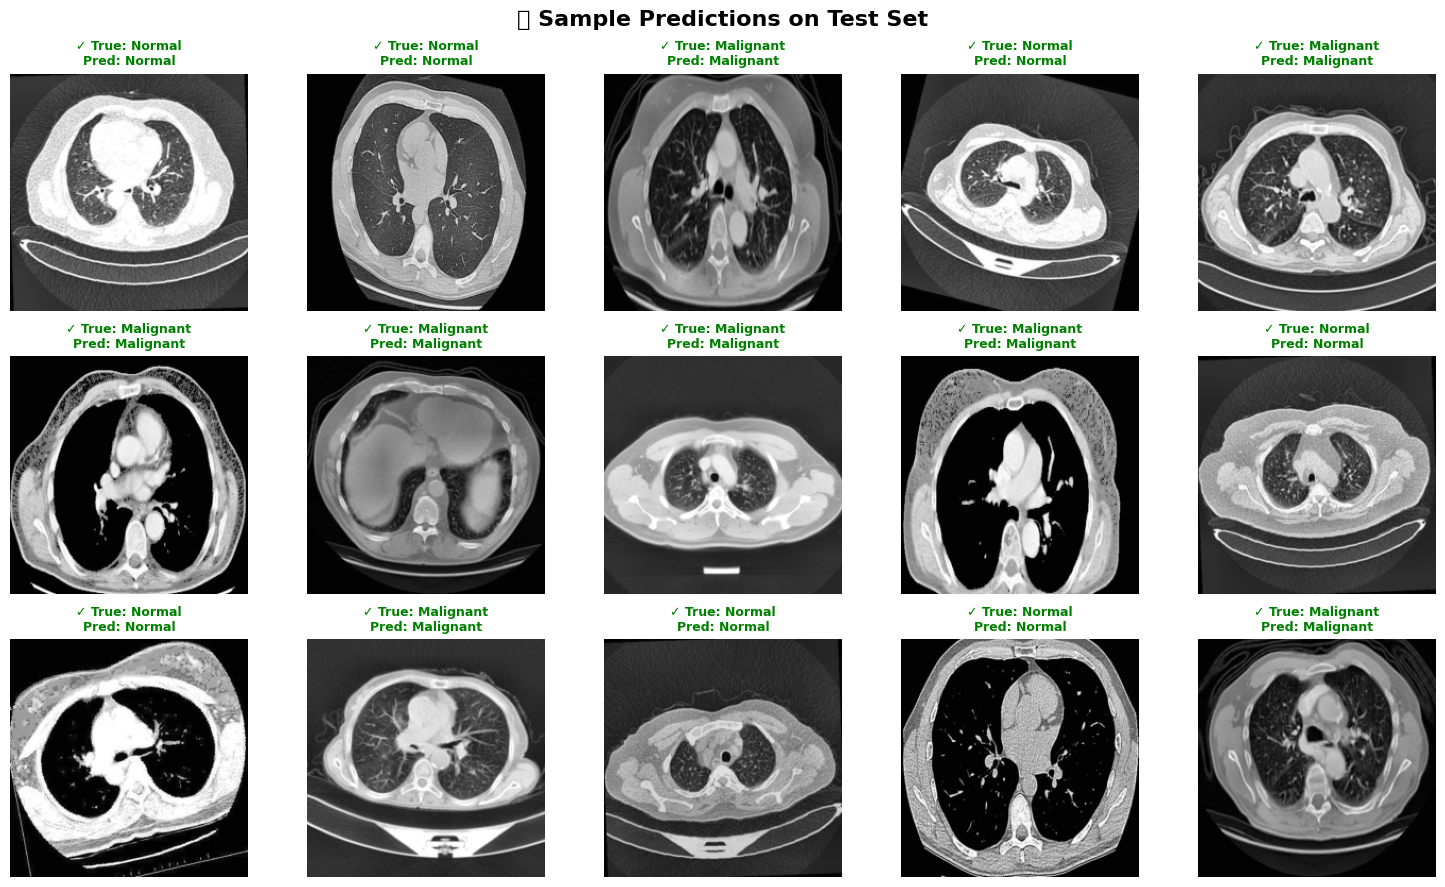

In [26]:
def visualize_predictions(model, dataset, class_names, num_images=15, device='cuda'):
    """Visualize model predictions on sample images"""
    model.eval()

    # Random sample
    indices = np.random.choice(len(dataset), num_images, replace=False)

    rows = 3
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 9))

    # Unnormalize parameters
    mean = torch.tensor([0.485, 0.485, 0.485]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.229, 0.229]).view(3, 1, 1)

    with torch.no_grad():
        for i, ax in enumerate(axes.flatten()):
            if i < len(indices):
                img, label = dataset[indices[i]]

                # Predict
                img_batch = img.unsqueeze(0).to(device)
                output = model(img_batch)
                _, predicted = torch.max(output, 1)
                pred_class = predicted.item()

                # Unnormalize image
                img = img * std + mean
                img = torch.clamp(img, 0, 1)
                img = img.numpy().transpose((1, 2, 0))

                # Display
                ax.imshow(img, cmap='gray')

                # Color: green if correct, red if wrong
                is_correct = (pred_class == label)
                color = 'green' if is_correct else 'red'
                symbol = '✓' if is_correct else '✗'

                title = f"{symbol} True: {class_names[label]}\nPred: {class_names[pred_class]}"
                ax.set_title(title, fontsize=9, color=color, fontweight='bold')
                ax.axis('off')
            else:
                ax.axis('off')

    plt.suptitle("🖼️ Sample Predictions on Test Set", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset, train_dataset.classes, num_images=15, device=device)

# 💾 Save Model

## What Gets Saved:

**1. Model State Dict (lung_cancer_cnn.pth):**
- Model weights and biases
- Use for inference/deployment
- Requires model architecture to load

**2. Complete Checkpoint (lung_cancer_checkpoint.pth):**
- Model state
- Optimizer state
- Training history
- Hyperparameters
- Use to resume training

## File Locations:
- Saved in the same directory as notebook
- Can be uploaded to cloud storage
- Use for deployment or further training

In [27]:
# Save model
save_dir = "."  # Current directory

# Save model state dict
model_path = os.path.join(save_dir, "lung_cancer_cnn.pth")
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")

# Save complete checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'test_accuracy': test_accuracy,
    'class_names': train_dataset.classes,
    'image_size': IMAGE_SIZE,
    'batch_size': BATCH_SIZE
}

checkpoint_path = os.path.join(save_dir, "lung_cancer_checkpoint.pth")
torch.save(checkpoint, checkpoint_path)
print(f"✅ Checkpoint saved to: {checkpoint_path}")

print("\n" + "=" * 70)
print("🎉 Training Pipeline Complete!")
print("=" * 70)
print(f"✅ Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Model files saved successfully")
print("=" * 70)

✅ Model saved to: ./lung_cancer_cnn.pth
✅ Checkpoint saved to: ./lung_cancer_checkpoint.pth

🎉 Training Pipeline Complete!
✅ Final Test Accuracy: 98.83%
✅ Model files saved successfully


# 🔄 How to Load and Use Saved Model

## Loading the Model:

Use this code to load the trained model for inference or deployment:

```python
# Create model instance
model = LungCancerCNN(num_classes=2)

# Load weights
model.load_state_dict(torch.load('lung_cancer_cnn.pth'))
model.to(device)
model.eval()

# Now ready for predictions!
```

## Making Predictions on New Images:

```python
from PIL import Image

# Load and preprocess image
img = Image.open('new_ct_scan.png')
img_tensor = val_test_transforms(img).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    
print(f"Prediction: {train_dataset.classes[predicted.item()]}")
```

# 🔥 Grad-CAM Visualization

## What is Grad-CAM?
**Grad-CAM** = Gradient-weighted Class Activation Mapping

### Why Use Grad-CAM?
- **Explainability:** Shows which image regions the model focuses on
- **Trust:** Verify model looks at tissue (not artifacts/background)
- **Debugging:** Identify if model learns spurious correlations
- **Medical validation:** Critical for clinical applications

### How Grad-CAM Works:
1. Forward pass → get predictions
2. Backward pass → compute gradients of target class w.r.t. feature maps
3. Weight feature maps by gradients
4. Generate heatmap showing important regions

### What to Look For:
- ✅ Model focuses on lung tissue
- ✅ Different attention for Normal vs Malignant
- ❌ Model focuses on borders/artifacts (bad!)

🔥 Generating Grad-CAM visualizations...



/tmp/ipython-input-709134178.py:129: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


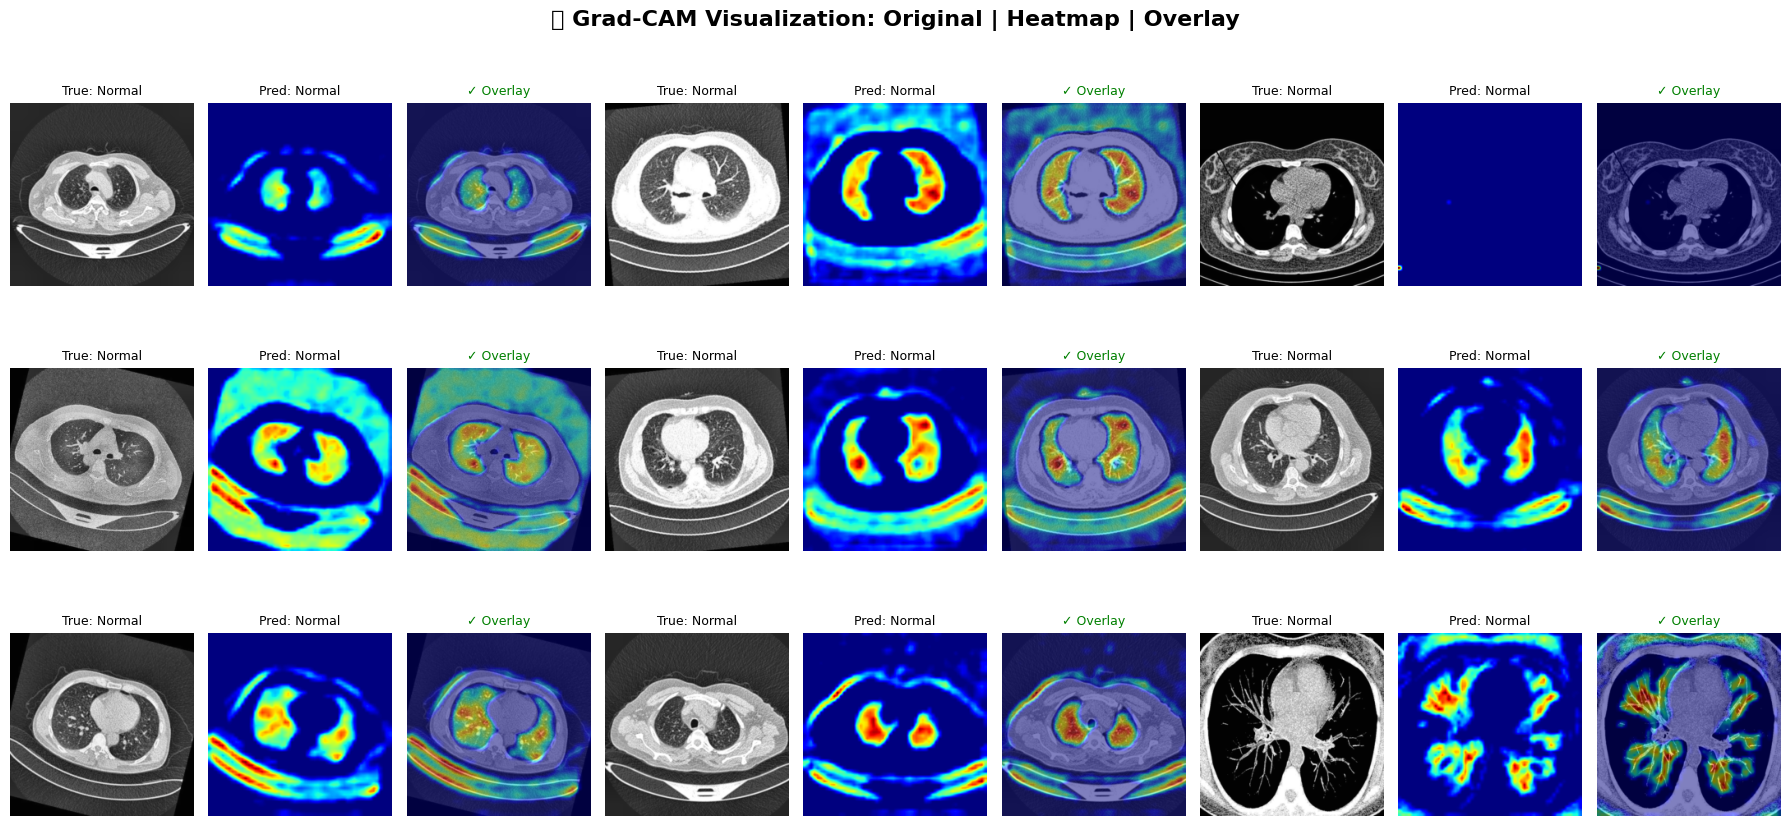

In [33]:
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap


class GradCAM:
    """Grad-CAM implementation for CNN visualization"""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        """Save forward pass activations"""
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        """Save backward pass gradients"""
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        """Generate Grad-CAM heatmap"""
        # Forward pass
        self.model.eval()
        output = self.model(input_image)

        # If no target class specified, use predicted class
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()

        # Generate CAM
        gradients = self.gradients[0]   # [C, H, W]
        activations = self.activations[0]   # [C, H, W]

        # Global average pooling on gradients
        weights = gradients.mean(dim=(1, 2))   # [C]

        # --- THE FIX IS HERE ---
        # Initialize cam on the same device as activations (GPU)
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=activations.device)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        # ReLU (only positive contributions)
        cam = F.relu(cam)

        # Normalize to [0, 1]
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        # Move to CPU for numpy conversion at the end
        return cam.cpu().numpy(), target_class


def visualize_gradcam(model, dataset, class_names, num_images=9, device='cuda'):
    """Visualize Grad-CAM for sample images"""

    # Create Grad-CAM object
    gradcam = GradCAM(model, target_layer=model.conv3)

    # Random sample
    indices = np.random.choice(len(dataset), num_images, replace=False)

    rows = 3
    cols = 3
    fig, axes = plt.subplots(rows, cols * 3, figsize=(18, 9))

    # --- FIX 1: Move normalization params to the same device as the images ---
    mean = torch.tensor([0.485, 0.485, 0.485]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.229, 0.229]).view(3, 1, 1).to(device)

    for idx, img_idx in enumerate(indices):
        img, label = dataset[img_idx]

        # Prepare batch and move to device
        img_batch = img.unsqueeze(0).to(device)

        # Generate CAM
        cam, pred_class = gradcam.generate_cam(img_batch)

        # --- FIX 2: Handle Un-normalization carefully ---
        # Since 'img_batch' is on GPU, we use the GPU versions of mean/std
        # Then we move the result to CPU for plotting with .cpu()
        img_display = img_batch.squeeze(0) * std + mean
        img_display = torch.clamp(img_display, 0, 1)
        img_display = img_display.cpu().numpy().transpose((1, 2, 0))

        # Resize CAM to match image size
        cam_resized = cv2.resize(cam, (224, 224))

        # Get row and column for subplots
        row = idx // cols
        col_base = (idx % cols) * 3

        # 1. Original Image
        axes[row, col_base].imshow(img_display, cmap='gray')
        axes[row, col_base].set_title(f'True: {class_names[label]}', fontsize=9)
        axes[row, col_base].axis('off')

        # 2. Grad-CAM Heatmap
        axes[row, col_base + 1].imshow(cam_resized, cmap='jet')
        axes[row, col_base + 1].set_title(f'Pred: {class_names[pred_class]}', fontsize=9)
        axes[row, col_base + 1].axis('off')

        # 3. Overlay
        axes[row, col_base + 2].imshow(img_display, cmap='gray')
        axes[row, col_base + 2].imshow(cam_resized, cmap='jet', alpha=0.5)

        # Color: green if correct, red if wrong
        is_correct = (pred_class == label)
        color = 'green' if is_correct else 'red'
        symbol = '✓' if is_correct else '✗'
        axes[row, col_base + 2].set_title(f'{symbol} Overlay', fontsize=9, color=color)
        axes[row, col_base + 2].axis('off')

    plt.suptitle('🔥 Grad-CAM Visualization: Original | Heatmap | Overlay',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Generate Grad-CAM visualizations
print("🔥 Generating Grad-CAM visualizations...\n")
visualize_gradcam(model, test_dataset, train_dataset.classes, num_images=9, device=device)


🔍 Comparing Grad-CAM for correct vs incorrect predictions...



/tmp/ipython-input-1918596127.py:78: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


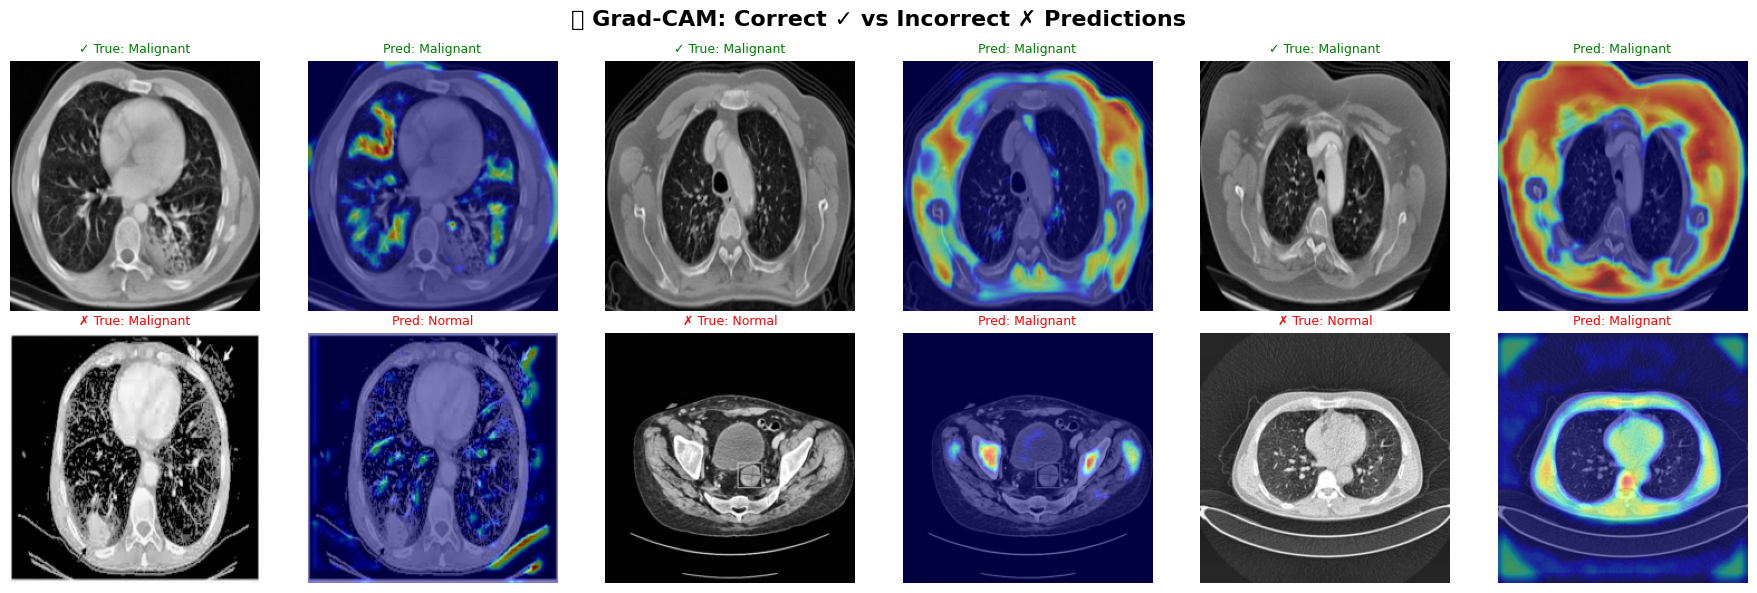

In [34]:
# Advanced: Compare Grad-CAM for Correct vs Incorrect Predictions

def visualize_gradcam_comparison(model, dataset, class_names, device='cuda'):
    """Compare Grad-CAM for correct and incorrect predictions"""

    gradcam = GradCAM(model, target_layer=model.conv3)

    # Find correct and incorrect predictions
    correct_indices = []
    incorrect_indices = []

    model.eval()
    with torch.no_grad():
        for idx in range(len(dataset)):
            img, label = dataset[idx]
            img_batch = img.unsqueeze(0).to(device)
            output = model(img_batch)
            pred = output.argmax(dim=1).item()

            if pred == label:
                correct_indices.append(idx)
            else:
                incorrect_indices.append(idx)

            if len(correct_indices) >= 3 and len(incorrect_indices) >= 3:
                break

    # Plot comparison
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))

    mean = torch.tensor([0.485, 0.485, 0.485]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.229, 0.229]).view(3, 1, 1)

    # Correct predictions (top row)
    for i, idx in enumerate(correct_indices[:3]):
        img, label = dataset[idx]
        img_batch = img.unsqueeze(0).to(device)
        cam, pred_class = gradcam.generate_cam(img_batch)

        img_display = img * std + mean
        img_display = torch.clamp(img_display, 0, 1).numpy().transpose((1, 2, 0))
        cam_resized = cv2.resize(cam, (224, 224))

        # Original
        axes[0, i*2].imshow(img_display, cmap='gray')
        axes[0, i*2].set_title(f'✓ True: {class_names[label]}', fontsize=9, color='green')
        axes[0, i*2].axis('off')

        # Overlay
        axes[0, i*2+1].imshow(img_display, cmap='gray')
        axes[0, i*2+1].imshow(cam_resized, cmap='jet', alpha=0.5)
        axes[0, i*2+1].set_title(f'Pred: {class_names[pred_class]}', fontsize=9, color='green')
        axes[0, i*2+1].axis('off')

    # Incorrect predictions (bottom row)
    for i, idx in enumerate(incorrect_indices[:3]):
        img, label = dataset[idx]
        img_batch = img.unsqueeze(0).to(device)
        cam, pred_class = gradcam.generate_cam(img_batch)

        img_display = img * std + mean
        img_display = torch.clamp(img_display, 0, 1).numpy().transpose((1, 2, 0))
        cam_resized = cv2.resize(cam, (224, 224))

        # Original
        axes[1, i*2].imshow(img_display, cmap='gray')
        axes[1, i*2].set_title(f'✗ True: {class_names[label]}', fontsize=9, color='red')
        axes[1, i*2].axis('off')

        # Overlay
        axes[1, i*2+1].imshow(img_display, cmap='gray')
        axes[1, i*2+1].imshow(cam_resized, cmap='jet', alpha=0.5)
        axes[1, i*2+1].set_title(f'Pred: {class_names[pred_class]}', fontsize=9, color='red')
        axes[1, i*2+1].axis('off')

    plt.suptitle('🔥 Grad-CAM: Correct ✓ vs Incorrect ✗ Predictions',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Compare correct vs incorrect
print("\n🔍 Comparing Grad-CAM for correct vs incorrect predictions...\n")
visualize_gradcam_comparison(model, test_dataset, train_dataset.classes, device=device)

# 📊 Grad-CAM Interpretation Guide

## What Good Grad-CAM Looks Like:
- ✅ **Focuses on lung tissue** (not borders/artifacts)
- ✅ **Different patterns** for Normal vs Malignant
- ✅ **Consistent attention** across similar cases
- ✅ **Localized hotspots** on suspicious regions

## What Bad Grad-CAM Looks Like:
- ❌ Focuses on image corners/edges
- ❌ Highlights background/artifacts
- ❌ Random scattered attention
- ❌ Same pattern for all classes

## Medical Insights:
For **Malignant cases**, model should focus on:
- Irregular tissue patterns
- Dense nodules or masses
- Texture abnormalities

For **Normal cases**, model should recognize:
- Regular tissue structure
- Uniform density
- Absence of abnormalities

## Next Steps:
If Grad-CAM shows problems:
1. Add more data augmentation
2. Use weighted loss (focus on tissue regions)
3. Try attention mechanisms in architecture
4. Use segmentation masks if available